In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import shutil
import re
import math
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import img_as_float32, img_as_ubyte
import pickle
import cv2

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

## Cria mascaras juntando left + right masks para Montgomery

In [2]:
from glob import glob
from tqdm import tqdm

DILATE_KERNEL = np.ones((15, 15), np.uint8)
MONTGOMERY_LEFT_MASK_DIR = "extra data/Montgomery/ManualMask/leftMask/"
MONTGOMERY_IMAGE_DIR = "extra data/Montgomery/images/"
MONTGOMERY_RIGHT_MASK_DIR = "extra data/Montgomery/ManualMask/rightMask/"
SEGMENTATION_DIR = "extra data/Montgomery/ManualMask/joined/"
SEGMENTATION_DILATE_DIR = "extra data/Montgomery/ManualMask/dilate/"

if os.path.exists(SEGMENTATION_DIR):
    shutil.rmtree(SEGMENTATION_DIR)
    shutil.rmtree(SEGMENTATION_DILATE_DIR)

os.mkdir(SEGMENTATION_DIR)
os.mkdir(SEGMENTATION_DILATE_DIR)
    

montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (400, 400))
    left_mask = cv2.resize(left_mask, (400, 400))
    right_mask = cv2.resize(right_mask, (400, 400))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    

    cv2.imwrite(os.path.join(SEGMENTATION_DIR, base_file), \
                    mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)


100%|██████████| 138/138 [00:32<00:00,  4.26it/s]


In [3]:
%matplotlib inline

## Cohen

In [4]:
root_folder = "../3_Images"
masks_folder = os.path.join(root_folder, "masks")

img_size = 400

In [5]:
images = []
labels = []
manual_images = []
v7labs_images = []

for mask_path in os.listdir(masks_folder):
  mask = imread(os.path.join(masks_folder, mask_path), cv2.IMREAD_GRAYSCALE)
  print('Original Dimensions : ',mask.shape)
 
  mask = np.float32(mask / 255)
  labels.append(mask)

  target, source, pathogen, pid, offset, _ = re.split("[_.]", mask_path)
  img_path = "%s_%s_%s_%s.png" % (source, pathogen, pid, offset)
  img = imread(os.path.join(root_folder, target, pathogen, img_path), cv2.IMREAD_GRAYSCALE)
  print('Original Dimensions : ',img.shape)
  img = img_as_float32(img)
  
  if source == "Cohen":
    v7labs_images.append(img)
  else:
    manual_images.append(img)
  
  images.append(img)
  
len(labels)

Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimen

Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimen

Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimen

Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimen

502

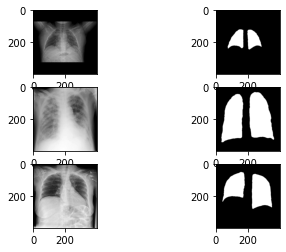

In [6]:
# Show some of our own CXR and masks
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(images[50], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(labels[50], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(labels[30], cmap = "gray")

## Montgomery

In [7]:
# Also load the Montgomery dataset that already contains manually segmented masks
montgomery_images = []
montgomery_labels = []
montgomery_folder = "extra data/Montgomery/"
for img_path in os.listdir(os.path.join(montgomery_folder, "images")):
    print(img_path)
    img_path_new = os.path.join(montgomery_folder, "images", img_path)
    img = imread(img_path_new, cv2.IMREAD_GRAYSCALE)
    
    
    print('Original Dimensions : ',img.shape)
 
    width = int(400)
    height = int(400)
    dim = (width, height)

    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    print('Resized Dimensions : ',img.shape)
 
    
    
    img = img_as_float32(img)
    montgomery_images.append(img)
    images.append(img)

    img_path_mask = os.path.join(montgomery_folder, "ManualMask", "joined", img_path)
    mask = imread(img_path_mask, cv2.IMREAD_GRAYSCALE)
    
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    
    mask = np.float32(mask / 255)
    print('Original Dimensions : ',mask.shape)
    montgomery_labels.append(mask)
    labels.append(mask)


MCUCXR_0027_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0294_1.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0282_1.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0087_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0031_0.png
Original Dimensions :  (4020, 4892)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0096_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0251_1.png
Original Dimensions :  (4020, 4892)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0099_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0058_0.png
Original Dimen

Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0003_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0051_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0375_1.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0026_0.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0103_0.png
Original Dimensions :  (4020, 4892)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0141_1.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0258_1.png
Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0126_1.png
Original Dimensions :  (4892, 40

Original Dimensions :  (4892, 4020)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
MCUCXR_0016_0.png
Original Dimensions :  (4020, 4892)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)


In [8]:
len(montgomery_labels)

138

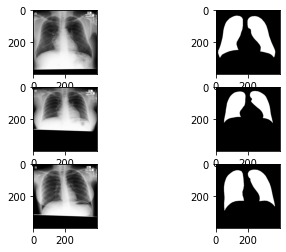

In [9]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(montgomery_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(montgomery_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(montgomery_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(montgomery_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(montgomery_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(montgomery_labels[30], cmap = "gray")

## JSRT

In [10]:
# Also load the JSRT dataset that already contains manually segmented masks
jsrt_images = []
jsrt_labels = []
jsrt_folder = "extra data/JSRT/"

for img_path in os.listdir(os.path.join(jsrt_folder, "Images")):
    img = imread(os.path.join(jsrt_folder, "Images", img_path), cv2.IMREAD_GRAYSCALE)
    img = img_as_float32(img)
    
    
    print('Original Dimensions : ',img.shape)

    width = int(400)
    height = int(400)
    dim = (width, height)

    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    print('Resized Dimensions : ',img.shape)
 
      
    jsrt_images.append(img)
    images.append(img)
  
    mask = imread(os.path.join(jsrt_folder, "Masks", img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)

    mask = np.float32(mask / 255)
    
    print('Original Dimensions : ',mask.shape)
    jsrt_labels.append(mask)
    labels.append(mask)

len(jsrt_labels)

Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Orig

Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Res

Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Res

Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Origin

Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Resized Dimensions :  (400, 400)
Original Dimensions :  (400, 400)
Original Dimensions :  (2048, 2048)
Res

385

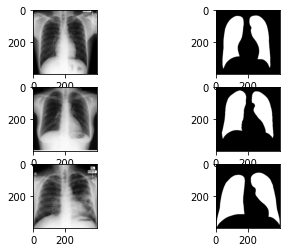

In [11]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(jsrt_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(jsrt_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(jsrt_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(jsrt_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(jsrt_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(jsrt_labels[30], cmap = "gray")

## Shenzen

In [12]:
# Also load the Shenzhen dataset that already contains manually segmented masks
shenzhen_images = []
shenzhen_labels = []
shenzhen_folder = "extra data/Shenzen/"
for img_path in os.listdir(os.path.join(shenzhen_folder, "images")):
  img = imread(os.path.join(shenzhen_folder, "images", img_path), cv2.IMREAD_GRAYSCALE)
  if len(img.shape) == 3:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  mask_name = img_path.split(".")[0] + "_mask.png"
  mask_path = os.path.join(shenzhen_folder, "Mask", mask_name)

  if os.path.exists(mask_path):  
      print('Original Dimensions : ',img.shape)

      width = int(400)
      height = int(400)
      dim = (width, height)

      # resize image
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

      print('Resized Dimensions : ',img.shape)  
      img = img_as_float32(img)
      shenzhen_images.append(img)
      images.append(img)

      mask = imread(mask_path, cv2.IMREAD_GRAYSCALE)
      if len(mask.shape) == 3:
          mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      print('Original Dimensions : ',mask.shape)
      mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
      mask = np.float32(mask / 255)
      print('Resized Dimensions : ',mask.shape)  
      shenzhen_labels.append(mask)
      labels.append(mask)

len(shenzhen_labels)

Original Dimensions :  (2939, 2985)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2939, 2985)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2947, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2947, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2080, 2119)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2080, 2119)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2525, 2234)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2525, 2234)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2897, 2499)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2897, 2499)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2203, 2260)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2203, 2260)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2457, 2997)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2457, 2997)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2319, 2384

Original Dimensions :  (2959, 2792)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2959, 2792)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2804, 2368)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2804, 2368)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2987, 2628)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2987, 2628)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2958, 2992)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2958, 2992)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2527, 2443)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2527, 2443)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2991, 2609)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2991, 2609)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2953, 3000

Original Dimensions :  (2947, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2947, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 2621)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 2621)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2990, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2990, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2931, 2511)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2931, 2511)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2986, 2995

Original Dimensions :  (2240, 2377)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2240, 2377)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2989, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2989, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2493, 2573)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2493, 2573)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2639, 2709)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2639, 2709)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2994, 2600)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2994, 2600)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2971, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2971, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2995, 2989

Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2958, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2958, 2991)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2933, 2987)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2933, 2987)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2666, 2511)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2666, 2511)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2603, 2516)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2603, 2516)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2960, 2776)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2960, 2776)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2731, 2733)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2731, 2733)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2945, 3000

Original Dimensions :  (2947, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2947, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2308, 2308)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2308, 2308)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2915, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2915, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2957, 2747)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2957, 2747)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2943, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2943, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2324, 2266)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2324, 2266)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2988, 3001

Original Dimensions :  (2946, 2994)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2946, 2994)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 2879)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 2879)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2562, 2464)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2562, 2464)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2693, 2544)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2693, 2544)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2993, 2967)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2993, 2967)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2998, 2573)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2998, 2573)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2970, 2406)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2970, 2406)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2974, 2631

Original Dimensions :  (2937, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2937, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2995, 2988)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2995, 2988)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2963, 3001)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2963, 3001)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2205, 1936)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2205, 1936)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2735, 2421)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2735, 2421)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2982, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2982, 2990)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2979, 2609)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2979, 2609)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2948, 2775

Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2935, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2944, 2485)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2944, 2485)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (3001, 2689)
Resized Dimensions :  (400, 400)
Original Dimensions :  (3001, 2689)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2928, 2464)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2928, 2464)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2949, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2944, 2994)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2944, 2994)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2705, 2406

Original Dimensions :  (2985, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2985, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2986)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2986)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 2989)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2951, 2989)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2989, 3001)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2989, 3001)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2417, 2618)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2417, 2618)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2941, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2941, 3000)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2992)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2992, 2992)
Resized Dimensions :  (400, 400)
Original Dimensions :  (2953, 2868

566

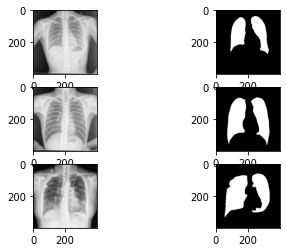

In [13]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(shenzhen_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(shenzhen_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(shenzhen_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(shenzhen_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(shenzhen_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(shenzhen_labels[30], cmap = "gray")

## Train, Test e Val

In [14]:
X = np.array(images).reshape((len(images), img_size, img_size, 1))
Y = np.array(labels).reshape((len(labels), img_size, img_size, 1))
X, Y = shuffle(X, Y, random_state = 1234)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.05, random_state = 1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.05, random_state = 1234)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X.shape)

(1435, 400, 400, 1)
(76, 400, 400, 1)
(80, 400, 400, 1)
(1591, 400, 400, 1)


In [15]:
shenzhen_test_ids = []
jsrt_test_ids = []
montgomery_test_ids = []
v7labs_test_ids = []
other_test_ids = []

nimages = X_test.shape[0]
for idx in range(nimages):
  test_image = X_test[idx,:,:,0]
  if any(np.array_equal(test_image, x) for x in shenzhen_images):
    shenzhen_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in montgomery_images):
    montgomery_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in jsrt_images):
    jsrt_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in v7labs_images):
    v7labs_test_ids.append(idx)
  else:
    other_test_ids.append(idx)

## Augmentation

In [16]:
class AugmentationSequence(keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size, augmentations):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.augment = augmentations

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    
    aug_x = np.zeros(batch_x.shape)
    aug_y = np.zeros(batch_y.shape)
    
    for idx in range(batch_x.shape[0]):
      aug = self.augment(image = batch_x[idx,:,:,:], mask = batch_y[idx,:,:,:])
      aug_x[idx,:,:,:] = aug["image"]
      aug_y[idx,:,:,:] = aug["mask"]
    
    return aug_x, aug_y

augment = Compose([
  HorizontalFlip(),
  ShiftScaleRotate(rotate_limit = 45, border_mode = cv2.BORDER_CONSTANT),
  ElasticTransform(border_mode = cv2.BORDER_CONSTANT),
  RandomBrightness(),
  RandomContrast(),
  RandomGamma()
])

batch_size = 16
train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Apply Augmentation

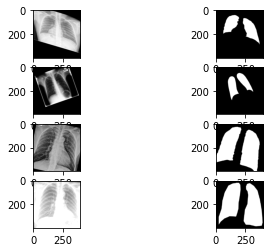

In [17]:
X_aug, Y_aug = train_generator.__getitem__(20)

f = plt.figure()
f.add_subplot(4, 2, 1)
plt.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 2)
plt.imshow(Y_aug[0,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 3)
plt.imshow(X_aug[1,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 4)
plt.imshow(Y_aug[1,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 5)
plt.imshow(X_aug[2,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 6)
plt.imshow(Y_aug[2,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 7)
plt.imshow(X_aug[3,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 8)
plt.imshow(Y_aug[3,:,:,0], cmap = "gray")

## Save Dataset

In [18]:
with open('input/train_dataset.pkl', 'wb') as file:
    pickle.dump(train_generator, file)

np.save('input/X_test.npy', X_test)
np.save('input/Y_test.npy', Y_test)
np.save('input/X_val.npy', X_val)
np.save('input/Y_val.npy', Y_val)
np.save('input/X_train.npy', X_train)
np.save('input/Y_train.npy', Y_train)

In [19]:
# Salvando epochs
text_file = open("input/epochs.txt", "wt")
n = text_file.write(str(steps_per_epoch))
text_file.close()